<a href="https://colab.research.google.com/github/nehayadav7295/stinky/blob/master/Stinky_GeoMaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary
* This notbook helps in Geographical plotting of complaints on maps and analyzing the effects of Weather data on number complaints. 
* The complaints are further segregated on the basis of their regions i.e., South Portland and Portland and weather data from nearest pods are considered.
*  The segregation on the basis of regions gives us a clear picture regarding the data collected by pods closest to them 





*   Visualizations in this notebook

   *   Frequency of complaints per day for temperature(F)
   *   Geographical plotting of complaints on basis of Wind direction, Wind direction in degrees, Average Temperature and month of complaint (The pods are shown in different size and color)
   *   Geographical plotting of complaints on basis of Wind direction and location of Terminals (different size and color)

   *   South Portland and Portland's separate Geographical plotting of complaints on basis of Wind direction, Wind direction in degrees and Average Temperature

# Instructions


* Run all blocks in sequence 
* Initial block contains some package installation which takes a few minutes to execute.
*  The basic idea is to get more details regarding the effect of weather on the number of complaints. By segregation on the basis of regions we can tell that temperature has different effects on Portland and South Portland.
*   The complaint data is merged with weather on the basis of pod's location(South Portland  or Portland) 

# Discussions 

*  The South Portland has most number of complaints in summer session and wind direction is North and West
* Portland  has most concentrated number of complaints from one area in winter session, hence temperature is low at that time. We can't associate any wind direction for that are because there seems to be uniform distribution for wind directions 

In [ ]:
#Installing geopy and related packages for geographical plotting 
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet
!pip install descartes --quiet
!pip install geopy
!pip install plotly_express
!pip install ipython-autotime
!pip install tqdm==4.36.0
%load_ext autotime
import pandas as pd

import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import matplotlib.pyplot as plt
import plotly_express as px
import tqdm
from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

Reading package lists...
Building dependency tree...
Reading state information...
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
python3-rtree is already the newest version (0.8.3+ds-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 27.3 s (started: 2021-08-21 04:12:53 +00:00)


#Loading the Data

In [ ]:
# Code taken from the Geo Team to get the tidied weather dataset
#@title 
#above string is used to hide code block
#PLEASE SEE FOLLOWING TEXT BLOCK FOR EXPLANATION OF THIS CODE CELL!!!
def add_dates_times_columns(df):
  # insert date only, time only, and DateTime Columns
  # adding a filler value x or y that will be replaced later
  df.insert(1, 'date_only', 'x')
  df.insert(2, 'time_only', 'y')
  
  # change name of Time column to datetime for clarity that it is a datetime
  df.rename(columns={'Time' : 'DateTime'}, inplace=True)
  #copy string of DateTime to time and date only columns
  df['date_only'] = df['DateTime']
  df['time_only'] = df['DateTime']

  # convert strings to appropriate data type - DateTime, date, and time
  df['DateTime'] = pd.to_datetime(df['DateTime'], format="%Y-%m-%d %H:%M:%S")
  df['date_only'] = pd.to_datetime(df['date_only']).dt.date
  df['time_only'] = pd.to_datetime(df['time_only']).dt.time

  # resetting index to make it look neat
  df.reset_index(drop=True, inplace=True)

def cardinal_direction(df): 
  condition_list = [(df['Wind Direction'] > 0) & (df['Wind Direction'] < 45), (df['Wind Direction'] == 45), 
                    (df['Wind Direction'] > 45) & (df['Wind Direction'] <= 90), (df['Wind Direction'] > 90) & (df['Wind Direction'] < 135), (df['Wind Direction'] == 135), 
                    (df['Wind Direction'] > 135) & (df['Wind Direction'] <= 180), (df['Wind Direction'] > 180) & (df['Wind Direction'] < 225), (df['Wind Direction'] == 225), 
                    (df['Wind Direction'] > 225) & (df['Wind Direction'] <= 270), (df['Wind Direction'] > 270) & (df['Wind Direction'] < 315), (df['Wind Direction'] == 315), 
                    (df['Wind Direction'] > 315) & (df['Wind Direction'] <= 360) ]
  choicelist = ['North','North-East', 'East', 'East', 'South-East', 'South', 'South', 'South-West', 'West', 'West', 'North-West', 'North']
  
  df['Cardinal Direction'] = np.select(condition_list, choicelist) #adding the cardinal direction column
  direction_values=df['Cardinal Direction'].values #to get the values either as array or a series
  
  df.drop(['Cardinal Direction'], axis=1, inplace=True) # we need to drop the column to relocate to the position we want
  df.insert(15,'Cardinal Direction',value=direction_values)
  return df # to return the dataframe when the function is called

def get_weather_master():
  try:
    !git clone https://github.com/hanihaider1/why-my-city-smell-bad-/
  except:
    exception = 1
  
  path = './why-my-city-smell-bad-/'
  lst = os.listdir(path)

  df= pd.DataFrame()
  df_new= pd.DataFrame()

  for i in lst:
    url = path+i
    if i[-4:]==".csv":
      if df.empty==True :
        df = pd.read_csv(url)
        df["Pod Name"] = i[:5]
      else:
        df_new= pd.read_csv(url)
        df_new["Pod Name"]= i[:5]
        df= df.append(df_new)

  add_dates_times_columns(df)
  df = cardinal_direction(df)

  df = df.sort_values(by=['Pod Name','DateTime'])
  df.reset_index(drop=True, inplace=True)
  df.rename(columns={'DateTime':'Date & time (hour rounded)', 
                     'date_only':'date', 'time_only':'time (hour rounded)'}
            , inplace=True)
  return df


time: 67.4 ms (started: 2021-08-21 04:13:20 +00:00)


In [ ]:
import os
#Loading the stinky, oil vessel and weather data into respective dataframes
url_stinky = 'https://raw.githubusercontent.com/ds5110/stinky/master/data/df_stinky.csv'
url_vessels = 'https://raw.githubusercontent.com/ds5110/stinky/master/data/df_vessels.csv'
df_weather = get_weather_master()


df_stinky = pd.read_csv(url_stinky)
df_vessels = pd.read_csv(url_vessels)
df_stinky.head()

fatal: destination path 'why-my-city-smell-bad-' already exists and is not an empty directory.


,Id,Report Source,Category,Created at local,Closed at local,Status,Address,smell description,URL,Latitude,Longitude,Export tagged places,date,time,Day,Month,Year,Hour,Month_name,Date & time (hour rounded),geom,address,South Portland/Portland,epoch time,date & time,smell value,zipcode,symptoms,additional comments
0,7181157.0,iPhone,Odor,2020-01-07 08:26:00,2020-01-07 09:20:00,Archived,315 Spring Street,Petroleum smell coming from south portland,https://crm.seeclickfix.com/#/organizations/61...,43.647740,-70.269455,City Council District 2,2020-01-07,08:26:00,7,1,2020,8,Jan,2020-01-07 08:00:00,"43.64774,-70.26945450000001","315, Spring Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN
1,7181402.0,Android,Odor,2020-01-07 09:11:00,2020-01-07 09:20:00,Archived,25 Cushman St,usual petroleum,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-01-07,09:11:00,7,1,2020,9,Jan,2020-01-07 09:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN
2,7192000.0,Android,Odor,2020-01-09 07:14:00,2020-01-09 08:45:00,Archived,25 Cushman St,usual petroleum,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-01-09,07:14:00,9,1,2020,7,Jan,2020-01-09 07:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN
3,7206428.0,Android,Odor,2020-01-13 08:22:00,2020-01-13 09:09:00,Archived,25 Cushman St,worst yet,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-01-13,08:22:00,13,1,2020,8,Jan,2020-01-13 08:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN
4,7210067.0,Android,Odor,2020-01-14 08:24:00,2020-01-14 14:50:00,Archived,25 Cushman St,usual petroleum stink. Cushman and Reiche play...,https://crm.seeclickfix.com/#/organizations/61...,43.649448,-70.268626,City Council District 2,2020-01-14,08:24:00,14,1,2020,8,Jan,2020-01-14 08:00:00,"43.6494485,-70.2686259","22, Cushman Street, West End, Portland, Cumber...",Portland,NaN,NaN,NaN,NaN,NaN,NaN


time: 501 ms (started: 2021-08-21 04:13:20 +00:00)


In [ ]:

def ColToStr(df,column_name):
  """
  input : df - Dataframe, column_name- Name of the column
  This function convert the column name of the dataframe into string type ans return the updated dataframe
  Output : df -Dataframe
  """
  df[column_name]=df[column_name].astype(str)
  return df
df_stinky=ColToStr(df_stinky,'date');

time: 6.71 ms (started: 2021-08-21 04:13:21 +00:00)


# Filtering Stinky dataframe by removing dates for which weather data is unavailable 

In [ ]:
def PreprocessStinky(df):
  """
  input : df -Stinky dataframe
  This function preprocess the stinky dataframe by removing the data for which weather data is unavailable.
  Renaming 'Date & time (hour rounded)' to 'DateTime' and convert it to pandas Datetime object to maintain uniformity while merging with weather dataframe.
  Sorts the datadrame on the basis of DateTime object because we need sorted data to merge dataframes
  returns - updated df
  
    """
  # Removing complaints dated before 2020-09-02
  df=df[df['Date & time (hour rounded)']>'2020-09-02 11:00:00']
  df = df.rename(columns={'Date & time (hour rounded)': 'DateTime'})
  #Renaming Date time column to 'DateTime' and removing the rows where Datetime is not available as we will use this column to merge with weather data
  df=df[df['DateTime'].notnull()]
  #Converting DateTime column to panda's datetime object  
  df['DateTime'] = pd.to_datetime(df['DateTime'])
  # Sorting the dataframe on the basis of DateTime column as we need sorted dataframe to merge the data
  df = df.sort_values('DateTime')
  return df
  
df_stinky1=PreprocessStinky(df_stinky) 

time: 15.6 ms (started: 2021-08-21 04:13:21 +00:00)


# Loading Weather data

In [ ]:

def PreprocessWeather(df):
  """
  Input - Weather dataframe
  This function preprocess the Weather dataframe by renaming 'Date & time (hour rounded)' to 'DateTime' and convert it to pandas Datetime object to maintain uniformity while merging with weather dataframe.
  Sorts the datadrame on the basis of DateTime object because we need sorted data to merge dataframes
  returns - updated df
  """
  #Renaming Date time column to 'DateTime'
  df = df.rename(columns={'Date & time (hour rounded)': 'DateTime'})
  #Converting DateTime column to panda's datetime object  
  df['DateTime'] = pd.to_datetime(df['DateTime'])

  # Sorting the dataframe on the basis of DateTime column as we need sorted dataframe to merge the data
  df = df.sort_values('DateTime')

  #df_weather_master = df_weather_master.sort_values('DateTime', inplace=True)
  return df
df_weather_master= PreprocessWeather(df_weather_master)

time: 27.9 ms (started: 2021-08-21 04:13:21 +00:00)


# Merging Stinky data with weather data

In [ ]:
# Merging on the basis of DateTime column, the data will be merged on the closest value available from weather data
merged_dataframe = pd.merge_asof(df_stinky1,df_weather_master, on="DateTime")
merged_df_huggingface= pd.merge_asof(huggingface_results,df_weather_master, on="DateTime")
#Merging 

def AddPodLocations(merged_dataframe,Lat,Long):
  """
  Input - merged_dataframe (dataframe) , Lat(List of Lat that are going to be added), Long(Long of Lat that are going to be added)
  This function add a new column 'Pod/Not Pod' which contains the size, in reference to size of point in geographical plotting.
  Add new rows in the dataframe which contains the location of Pods and different size value for 'Pod/Not Pod' column value
  return- updated dataframe
  """
  #Creating a new Column which will help us in differentiating the pods from complaints while plotting
  merged_dataframe["Pod/Not Pod"]=0.01
  for i in range(len(Lat)):
    merged_dataframe = merged_dataframe.append({'Latitude' : Lat[i],'Longitude' : Long[i],'Cardinal Direction' : '0', 'Pod/Not Pod' : 0.2} , ignore_index=True)
  return merged_dataframe

Lat=[43.659321,43.638339,43.644338,43.653372,43.659877]
Long=[-70.271760,-70.269286,-70.268327,-70.234463,-70.246592]

merged_dataframe=AddPodLocations(merged_dataframe,Lat,Long)

time: 163 ms (started: 2021-08-21 04:13:21 +00:00)


In [ ]:
# Merging on the basis of DateTime column, the data will be merged on the closest value available from weather data
merged_dataframe_terminal = pd.merge_asof(df_stinky1,df_weather_master, on="DateTime")
df_huggingface_terminal=pd.merge_asof(huggingface_results,df_weather_master, on="DateTime")
#Adding terminal location in merged dataframe 
Lat=[43.63752544238322,43.63706063528992,43.6498744275754,43.637476254815944,43.63450125967064,43.76226155616127,43.64703757317286]
Long=[-70.26858981462888,-70.28547949671125,-70.2392658465595,-70.28568138856714,-70.27563613665191,-70.14076113096043,-70.24436331996561]

def AddTerminalLocations(merged_dataframe_terminal,Lat,Long):
  """
  This function add a new column 'Terminal/Not Terminal' which contains the size, in reference to size of point in geographical plotting.
  Add new rows in the dataframe which contains the location of Terminals and different size value for 'Terminal/Not Terminal' column value
  """

  #Creating a new Column which will help us in differentiating the pods from complaints while plotting
  merged_dataframe_terminal["Terminal/Not Terminal"]=0.01
  for i in range(len(Lat)):
    merged_dataframe_terminal = merged_dataframe_terminal.append({'Latitude' : Lat[i],'Longitude' : Long[i],'Cardinal Direction' : '0', 'Terminal/Not Terminal' : 0.2} , ignore_index=True)
  return merged_dataframe_terminal

#Final Merged Dataframe
merged_dataframe_terminal=AddTerminalLocations(merged_dataframe_terminal,Lat,Long)

time: 186 ms (started: 2021-08-21 04:13:21 +00:00)


# Temperature vs Frequency of complaints

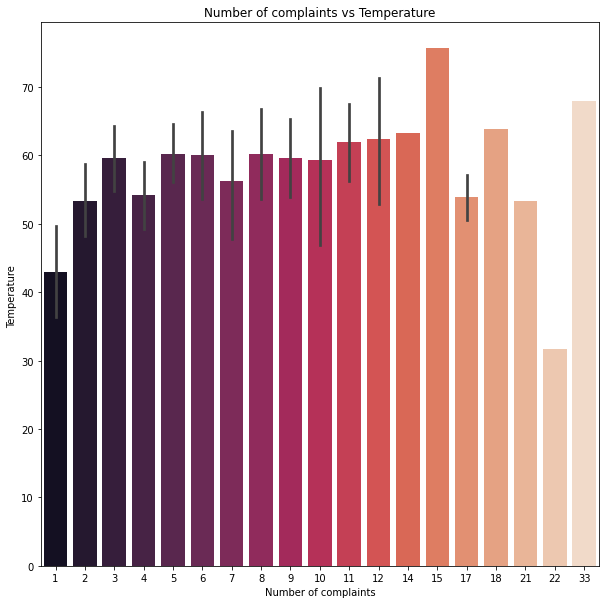

time: 769 ms (started: 2021-08-21 04:13:21 +00:00)


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string

# Creating a new dataframe so that we don't make any changes in original dataframe
#Sorting rows by Average temperature 
temp_df=merged_dataframe.sort_values(by=['Temp Avg'])
# Removing rows with no temperature data
temp_df=temp_df[temp_df['Temp Avg'].notnull()]

#Calculating frequency of complaints on same dates
temp_df['freq'] = temp_df.groupby('date_y')['date_y'].transform('count')
Freq_perday=temp_df.drop_duplicates(subset=['date_y'], keep='last')

#Removing duplicates
Freq_perday.set_index(['Latitude','Longitude']).index.is_unique

#Final dataframe containing Frequency of complaint per day and average temperature of that day 
Freq_perday


#Plotting Frequency of complains vs Temperature 
fig, ax = plt.subplots()
f=sns.barplot(data=Freq_perday,x='freq',y='Temp Avg',palette='rocket')
f.set(xlabel='Number of complaints',ylabel='Temperature ',title='Number of complaints vs Temperature');
fig.set_size_inches(10,10)

# Plotting Geographical data

In [ ]:
import plotly_express as px
px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
  
def PlotGeographicalData(df,color_seq,hue_column,size_column):
  """
  This function plots the Latitude and Longitude columns of the provided dataframe, representing with different 
  color and size on the basis of values of columns hue_column and size_column respectively.
  """
  df=df.sort_values(by=[hue_column])
  return px.scatter_mapbox(df, lat="Latitude", lon="Longitude",color_discrete_sequence= color_seq , zoom=12, color=hue_column ,size=size_column)

time: 3.04 ms (started: 2021-08-21 04:13:22 +00:00)


# Plotting the complaint location with different colors on the basis of wind direction
### The red dots are the Pods

In [ ]:
PlotGeographicalData(merged_dataframe,px.colors.sequential.Rainbow_r,'Cardinal Direction','Pod/Not Pod')

time: 379 ms (started: 2021-08-21 04:13:22 +00:00)


# Plotting the complaint location with different colours on the basis of wind direction
### The red dots are the Terminals

In [ ]:

PlotGeographicalData(merged_dataframe_terminal,px.colors.sequential.Rainbow_r,'Cardinal Direction','Terminal/Not Terminal')


time: 382 ms (started: 2021-08-21 04:13:22 +00:00)


# Plotting the complaint location with different colors  on the basis of month of complaint
### The black / bigger dots are the Pods

In [ ]:
import plotly_express as px

# Removing complaints for which date is not available
merged_dataframe['Month']=merged_dataframe['Month'].fillna(0)
merged_dataframe=ColToStr(merged_dataframe,'Month');

#Descending the data by date for better visualization
merged_dataframe=merged_dataframe.sort_values('date_y',ascending=False)


PlotGeographicalData(merged_dataframe,px.colors.cyclical.IceFire_r,'Month','Pod/Not Pod')


time: 402 ms (started: 2021-08-21 04:13:23 +00:00)


# Plotting the complaint location with different colours on the basis of wind direction in degrees
### The black dots are the Pods

In [ ]:

PlotGeographicalData(merged_dataframe,px.colors.cyclical.mrybm_r,'Wind Direction','Pod/Not Pod')

time: 947 ms (started: 2021-08-21 04:13:23 +00:00)


# Plotting the complaint location with different colours on the basis of Average Temperature
### The black dots are the Pods

In [ ]:

PlotGeographicalData(merged_dataframe,px.colors.cyclical.mrybm_r,'Temp Avg','Pod/Not Pod')

time: 325 ms (started: 2021-08-21 04:13:24 +00:00)


# South Portland vs Portland

In [ ]:
# Segregation of dataframe on the basis of region

South_portland= df_stinky1[df_stinky1['South Portland/Portland']=='South Portland']
Portland=df_stinky1[df_stinky1['South Portland/Portland']!='South Portland']

time: 6.02 ms (started: 2021-08-21 04:13:24 +00:00)


### Merging Weather data with South portland and portland provided by the closest Pods

In [ ]:
#Filtering weather data on the basis of pods that we are considering for South portland and Portland
# Pods for South Portland are SMRO4,SMRO5,SMRO6
# Pods for Portland are SMRO3,SMRO4,SMRO5,SMRO7
df_weather_master_SouthP=df_weather_master[df_weather_master['Pod Name'].isin(['SMRO4','SMRO5','SMRO6']) ]
df_weather_master_Port=df_weather_master[df_weather_master['Pod Name'].isin(['SMRO3','SMRO4','SMRO5','SMRO7']) ]

time: 18.5 ms (started: 2021-08-21 04:13:24 +00:00)


#### Merging data for Portland 

In [ ]:
#Converting DateTime column to pandas datetime object 
df_weather_master_Port['DateTime'] = pd.to_datetime(df_weather_master_Port['DateTime'])
Portland['DateTime'] = pd.to_datetime(Portland['DateTime'])

# Merging on the basis of DateTime column, the data will be merged on the closest value available from weather data
merged_dataframe_Port = pd.merge_asof(Portland,df_weather_master_Port, on="DateTime")

Lat=[43.659321,43.638339,43.644338,43.653372]
Long=[-70.271760,-70.269286,-70.268327,-70.234463]

merged_dataframe_Port=AddPodLocations(merged_dataframe_Port,Lat,Long)

#Adding pods location in merged dataframe 
merged_dataframe_Port['Cardinal Direction'] = merged_dataframe_Port['Cardinal Direction'].fillna(0)

#Drop rows which doesn't contain weather data
merged_dataframe_Port=merged_dataframe_Port.dropna(subset=['Cardinal Direction'])

#Final South Portland stinky and weather data
merged_dataframe_Port

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Id,Report Source,Category,Created at local,Closed at local,Status,Address,smell description,URL,Latitude,Longitude,Export tagged places,date_x,time,Day,Month,Year,Hour,Month_name,DateTime,geom,address,South Portland/Portland,epoch time,date & time,smell value,zipcode,symptoms,additional comments,date_y,time (hour rounded),Temp Avg,Temp Low,Temp High,Hum Avg,Hum Low,Hum High,Baro Avg,Baro Low,Baro High,Windspeed,Gust,Wind Direction,Cardinal Direction,Interval Precip,Leaf Wetness (Minutes),Solar Radiation Avg,Inside Temp Avg,Inside Temp Low,Inside Temp High,Heat Index,Wind Chill,Dew Point,UV Index,Station Voltage,Station Voltage 2,t1ia,t1il,t1ih,t2ia,t2il,t2ih,wetbulb,s2ia,smia,lvl1,lvl2,lvl3,Pod Name,Pod/Not Pod
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Strong asphalt odor,NaN,43.644900,-70.276000,NaN,2020-09-02,19:01:41,2.0,9.0,2020.0,19.0,Sep,2020-09-02 19:00:00,NaN,NaN,Portland,1.599088e+09,2020-09-02 19:01:41,3.0,4102.0,NaN,NaN,2020-09-02,19:00:00,75.59,75.2,75.7,61.0,61.0,61.0,29.82,29.81,29.83,0.00000,0.0,135.0,South-East,0.0,NaN,NaN,75.00,75.0,75.0,75.59,75.6,61.2,NaN,6.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.6,NaN,NaN,NaN,NaN,NaN,SMRO3,0.01
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Asphalt/oul,NaN,43.649200,-70.277100,NaN,2020-09-02,19:10:01,2.0,9.0,2020.0,19.0,Sep,2020-09-02 19:00:00,NaN,NaN,Portland,1.599088e+09,2020-09-02 19:10:01,4.0,4102.0,NaN,NaN,2020-09-02,19:00:00,75.59,75.2,75.7,61.0,61.0,61.0,29.82,29.81,29.83,0.00000,0.0,135.0,South-East,0.0,NaN,NaN,75.00,75.0,75.0,75.59,75.6,61.2,NaN,6.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.6,NaN,NaN,NaN,NaN,NaN,SMRO3,0.01
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Asphalt/oil,NaN,43.648800,-70.275800,NaN,2020-09-02,19:08:07,2.0,9.0,2020.0,19.0,Sep,2020-09-02 19:00:00,NaN,NaN,Portland,1.599088e+09,2020-09-02 19:08:07,4.0,4102.0,NaN,NaN,2020-09-02,19:00:00,75.59,75.2,75.7,61.0,61.0,61.0,29.82,29.81,29.83,0.00000,0.0,135.0,South-East,0.0,NaN,NaN,75.00,75.0,75.0,75.59,75.6,61.2,NaN,6.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.6,NaN,NaN,NaN,NaN,NaN,SMRO3,0.01
3,8517698.0,iPhone,Odor,2020-09-02 22:02:00,2020-09-04 08:36:00,Archived,380 Danforth St,Asphalt smell is headache inducing. Southerly...,https://crm.seeclickfix.com/#/organizations/61...,43.644688,-70.271075,City Council District 2,2020-09-02,22:02:00,2.0,9.0,2020.0,22.0,Sep,2020-09-02 22:00:00,"43.64468763,-70.27107526","380, Danforth Street, West End, Portland, Cumb...",Portland,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-02,22:00:00,74.33,74.2,74.5,62.0,62.0,62.0,29.78,29.76,29.79,0.00000,0.0,135.0,South-East,0.0,NaN,NaN,74.00,74.0,74.0,74.33,74.3,60.4,NaN,6.500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.4,NaN,NaN,NaN,NaN,NaN,SMRO3,0.01
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oil/asphalt,NaN,43.650700,-70.277200,NaN,2020-09-05,06:13:20,5.0,9.0,2020.0,6.0,Sep,2020-09-05 06:00:00,NaN,NaN,Portland,1.599301e+09,2020-09-05 06:13:20,5.0,4102.0,Had to close the windows,NaN,2020-09-05,06:00:00,72.53,72.5,72.7,58.0,58.0,58.0,30.02,30.01,30.03,0.00000,0.0,135.0,South-East,0.0,NaN,NaN,72.98,72.0,73.0,72.53,72.5,56.9,NaN,6.501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.8,NaN,NaN,NaN,NaN,NaN,SMRO3,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.651800,-70.273600,NaN,2021-07-22,19:10:56,22.0,7.0,2021.0,19.0,Jul,2021-07-22 19:00:00,NaN,NaN,Portland,1.626995e+09,2021-07-22 19:10:56,4.0,4102.0,NaN,NaN,2021-07-22,19:00:00,73.96,72.7,75.7,59.0,57.0,61.0,30.02,30.01,30.03,3.85333,10.0,194.0,South,0.0,NaN,NaN,83.00,83.0,83.0,73.96,74.0,58.8,NaN,7.013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.3,NaN,NaN,NaN,NaN,NaN,SMRO7,0.01
349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.659321,-70.271760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

time: 291 ms (started: 2021-08-21 04:13:24 +00:00)


#### Merging data for South Portland 

In [ ]:
#Converting DateTime column to pandas datetime object 
df_weather_master_SouthP['DateTime'] = pd.to_datetime(df_weather_master_SouthP['DateTime'])
South_portland['DateTime'] = pd.to_datetime(South_portland['DateTime'])
South_portland = South_portland.sort_values('DateTime')

# Merging on the basis of DateTime column, the data will be merged on the closest value available from weather data
merged_dataframe_sp = pd.merge_asof(South_portland,df_weather_master_SouthP, on="DateTime")


Lat=[43.638339,43.644338,43.653372]
Long=[-70.269286,-70.268327,-70.234463]
#Adding pods location in merged dataframe 
merged_dataframe_sp=AddPodLocations(merged_dataframe_sp,Lat,Long)

#Drop rows which doesn't contain weather data
merged_dataframe_sp=merged_dataframe_sp.dropna(subset=['Cardinal Direction'])

#Final South Portland stinky and weather data
merged_dataframe_sp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Id,Report Source,Category,Created at local,Closed at local,Status,Address,smell description,URL,Latitude,Longitude,Export tagged places,date_x,time,Day,Month,Year,Hour,Month_name,DateTime,geom,address,South Portland/Portland,epoch time,date & time,smell value,zipcode,symptoms,additional comments,date_y,time (hour rounded),Temp Avg,Temp Low,Temp High,Hum Avg,Hum Low,Hum High,Baro Avg,Baro Low,Baro High,Windspeed,Gust,Wind Direction,Cardinal Direction,Interval Precip,Leaf Wetness (Minutes),Solar Radiation Avg,Inside Temp Avg,Inside Temp Low,Inside Temp High,Heat Index,Wind Chill,Dew Point,UV Index,Station Voltage,Station Voltage 2,t1ia,t1il,t1ih,t2ia,t2il,t2ih,wetbulb,s2ia,smia,lvl1,lvl2,lvl3,Pod Name,Pod/Not Pod
247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Petroleum tank fumes,NaN,43.636600,-70.269800,NaN,2020-11-14,09:37:39,14.0,11.0,2020.0,9.0,Nov,2020-11-14 09:00:00,NaN,NaN,South Portland,1.605365e+09,2020-11-14 09:37:39,3.0,4106.0,Headache,NaN,2020-11-14,09:00:00,73.00,73.0,73.0,37.0,36.0,37.0,29.83,29.82,29.84,0.00000,0.0,292.0,West,0.0,NaN,NaN,73.02,73.0,73.0,73.00,73.0,45.0,NaN,7.452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.3,NaN,NaN,NaN,NaN,NaN,SMRO4,0.01
248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.634700,-70.281800,NaN,2020-11-14,09:10:22,14.0,11.0,2020.0,9.0,Nov,2020-11-14 09:00:00,NaN,NaN,South Portland,1.605363e+09,2020-11-14 09:10:22,3.0,4106.0,NaN,NaN,2020-11-14,09:00:00,73.00,73.0,73.0,37.0,36.0,37.0,29.83,29.82,29.84,0.00000,0.0,292.0,West,0.0,NaN,NaN,73.02,73.0,73.0,73.00,73.0,45.0,NaN,7.452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.3,NaN,NaN,NaN,NaN,NaN,SMRO4,0.01
249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Rotten eggs, sulphur",NaN,43.634800,-70.272000,NaN,2020-11-14,14:24:29,14.0,11.0,2020.0,14.0,Nov,2020-11-14 14:00:00,NaN,NaN,South Portland,1.605382e+09,2020-11-14 14:24:29,5.0,4106.0,Nausea,NaN,2020-11-14,14:00:00,73.00,73.0,73.0,36.0,36.0,36.0,29.85,29.84,29.86,0.00000,0.0,292.0,West,0.0,NaN,NaN,74.00,74.0,74.0,73.00,73.0,44.5,NaN,7.458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.1,NaN,NaN,NaN,NaN,NaN,SMRO4,0.01
250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Petroleum tank fumes,NaN,43.635100,-70.268800,NaN,2020-11-14,15:49:39,14.0,11.0,2020.0,15.0,Nov,2020-11-14 15:00:00,NaN,NaN,South Portland,1.605387e+09,2020-11-14 15:49:39,4.0,4106.0,Headache,NaN,2020-11-14,15:00:00,73.00,73.0,73.0,36.0,36.0,36.0,29.88,29.86,29.89,0.00000,0.0,292.0,West,0.0,NaN,NaN,74.00,74.0,74.0,73.00,73.0,44.5,NaN,7.457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57.2,NaN,NaN,NaN,NaN,NaN,SMRO4,0.01
251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oil,NaN,43.630500,-70.273400,NaN,2020-11-14,17:11:37,14.0,11.0,2020.0,17.0,Nov,2020-11-14 17:00:00,NaN,NaN,South Portland,1.605392e+09,2020-11-14 17:11:37,5.0,4106.0,Headache,NaN,2020-11-14,17:00:00,73.00,73.0,73.0,35.0,35.0,35.0,29.94,29.93,29.95,0.00000,0.0,292.0,West,0.0,NaN,NaN,74.00,74.0,74.0,73.00,73.0,43.7,NaN,7.458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,56.9,NaN,NaN,NaN,NaN,NaN,SMRO4,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tar,NaN,43.632500,-70.273100,NaN,2021-07-23,08:28:44,23.0,7.0,2021.0,8.0,Jul,2021-07-23 08:00:00,NaN,NaN,South Portland,1.627043e+09,2021-07-23 08:28:44,3.0,4106.0,NaN,NaN,2021-07-23,08:00:00,65.31,62.0,69.0,79.0,73.0,87.0,30.12,30.11,30.12,2.35833,7.2,292.0,West,0.0,NaN,NaN,70.31,67.0,72.0,65.31,65.3,58.4,NaN,6.816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.0,NaN,NaN,NaN,NaN,NaN,SMRO6,0.01
944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Tar and oil, burning rubber",NaN,43.633700,-70.267500,NaN,2021-07-23,08:33:13,23.0,7.0,2021.0,8.0,Jul,2021-07-23 08:00:00,NaN,NaN,South Portland,1.627044e+09,2021-07-23 08:33:13,5.0,4106.0,Headache and nausea,NaN,2021-07-23,08:00:00,65.31,62.0,69.0,79.0,73.0,87.0,30.12,30.11,30.12,2.35833,7.2,292.0,West,0.0,NaN,NaN,70.31,67.0,72.0,65.31,65.3,58.4,NaN,6.816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.0,NaN,Na

time: 273 ms (started: 2021-08-21 04:13:25 +00:00)


# South Portland Data Plotting

## Plotting the South Portland complaint location with different colours on the basis of Wind Direction
### The red dots are the Pods

In [ ]:

merged_dataframe_sp=ColToStr(merged_dataframe_sp,'Cardinal Direction');
PlotGeographicalData(merged_dataframe_sp,px.colors.sequential.Rainbow_r,'Cardinal Direction','Pod/Not Pod')


time: 386 ms (started: 2021-08-21 04:13:25 +00:00)


## Plotting the South Portland complaint location with different colours on the basis of Wind Direction (degrees)
### The black dots are the Pods

In [ ]:

PlotGeographicalData(merged_dataframe_sp,px.colors.sequential.Rainbow_r,'Wind Direction','Pod/Not Pod')

time: 320 ms (started: 2021-08-21 04:13:25 +00:00)


## Plotting the South Portland complaint location with different colours on the basis of Average Temperature
### The black dots are the Pods

In [ ]:

PlotGeographicalData(merged_dataframe_sp,px.colors.sequential.Rainbow_r,'Temp Avg','Pod/Not Pod')

time: 335 ms (started: 2021-08-21 04:13:26 +00:00)


# Portland Data Plotting

## Plotting the Portland complaint location with different colours on the basis of Wind Direction
### The red dots are the Pods

In [ ]:
merged_dataframe_Port=ColToStr(merged_dataframe_Port,'Cardinal Direction');
PlotGeographicalData(merged_dataframe_Port,px.colors.sequential.Rainbow_r,'Cardinal Direction','Pod/Not Pod')

time: 371 ms (started: 2021-08-21 04:13:26 +00:00)


## Plotting the Portland complaint location with different colours on the basis of Wind Direction(Degree)
### The black dots are the Pods

In [ ]:

PlotGeographicalData(merged_dataframe_Port,px.colors.sequential.Rainbow_r,'Wind Direction','Pod/Not Pod')

time: 328 ms (started: 2021-08-21 04:13:26 +00:00)


## Plotting the Portland complaint location with different colours on the basis of Average Temperature
### The black dots are the Pods

In [ ]:

PlotGeographicalData(merged_dataframe_Port,px.colors.sequential.Rainbow_r,'Temp Avg','Pod/Not Pod')

time: 320 ms (started: 2021-08-21 04:13:27 +00:00)
